<a href="https://colab.research.google.com/github/addinar/permafrost-modeling-convlstm/blob/main/data/notebooks/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
from sklearn.preprocessing import StandardScaler

# **Multicollinearity Analysis**

In [4]:
# needed if running on colab
from google.colab import drive, userdata
drive.mount('/content/drive')
path = userdata.get('dataset_path')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
permafrost_data = pd.read_csv(path)

In [34]:
# keep original copy in case
orig = permafrost_data.copy()

In [13]:
# check columns
permafrost_data.columns

Index(['Unnamed: 0', 'date', 'lake_bottom_temperature', 'lake_ice_depth',
       'lake_ice_temperature', 'lake_mix_layer_depth',
       'lake_mix_layer_temperature', 'lake_shape_factor',
       'lake_total_layer_temperature', 'leaf_area_index_high_vegetation',
       'leaf_area_index_low_vegetation', 'snow_albedo', 'snow_cover',
       'snow_density', 'snow_depth', 'snow_depth_water_equivalent',
       'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer',
       'soil_temperature_level_1', 'soil_temperature_level_2',
       'soil_temperature_level_3', 'soil_temperature_level_4',
       'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2',
       'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
       'forecast_albedo', 'surface_latent_heat_flux_sum',
       'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum',
       'surface_sensible_heat_flux_sum',
       'surface_solar_radiation_downwards_sum',
       'surface_thermal_radiation_d

In [14]:
# temporarily remove 'date', 'band', and label columns
permafrost_data_new = permafrost_data.drop(columns=['date', 'band', 'TBFI_skin_temperature', 'TBFI_soil_temperature_level_1',
       'TBFI_soil_temperature_level_2', 'TBFI_soil_temperature_level_3'], axis=1)

Now we will view the heatmap of the pearson correlation.

Now compute **Variance Inflation Factor** (or VIF).

In [16]:
def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i)
                       for i in range(df.shape[1])]
    return vif_data

In [17]:
vif_result = compute_vif(permafrost_data_new)

In [18]:
vif_result

,feature,VIF
0,Unnamed: 0,14.018856
1,lake_bottom_temperature,28.133217
2,lake_ice_depth,9.592775
3,lake_ice_temperature,43.442107
4,lake_mix_layer_depth,2.255607
5,lake_mix_layer_temperature,80.797452
6,lake_shape_factor,3.300900
7,lake_total_layer_temperature,171.296594
8,leaf_area_index_high_vegetation,10.200769
9,leaf_area_index_low_vegetation,2.146124


A LOT of the VIF's are over-inflated! We will look at the heatmap to see which features are too correlated.

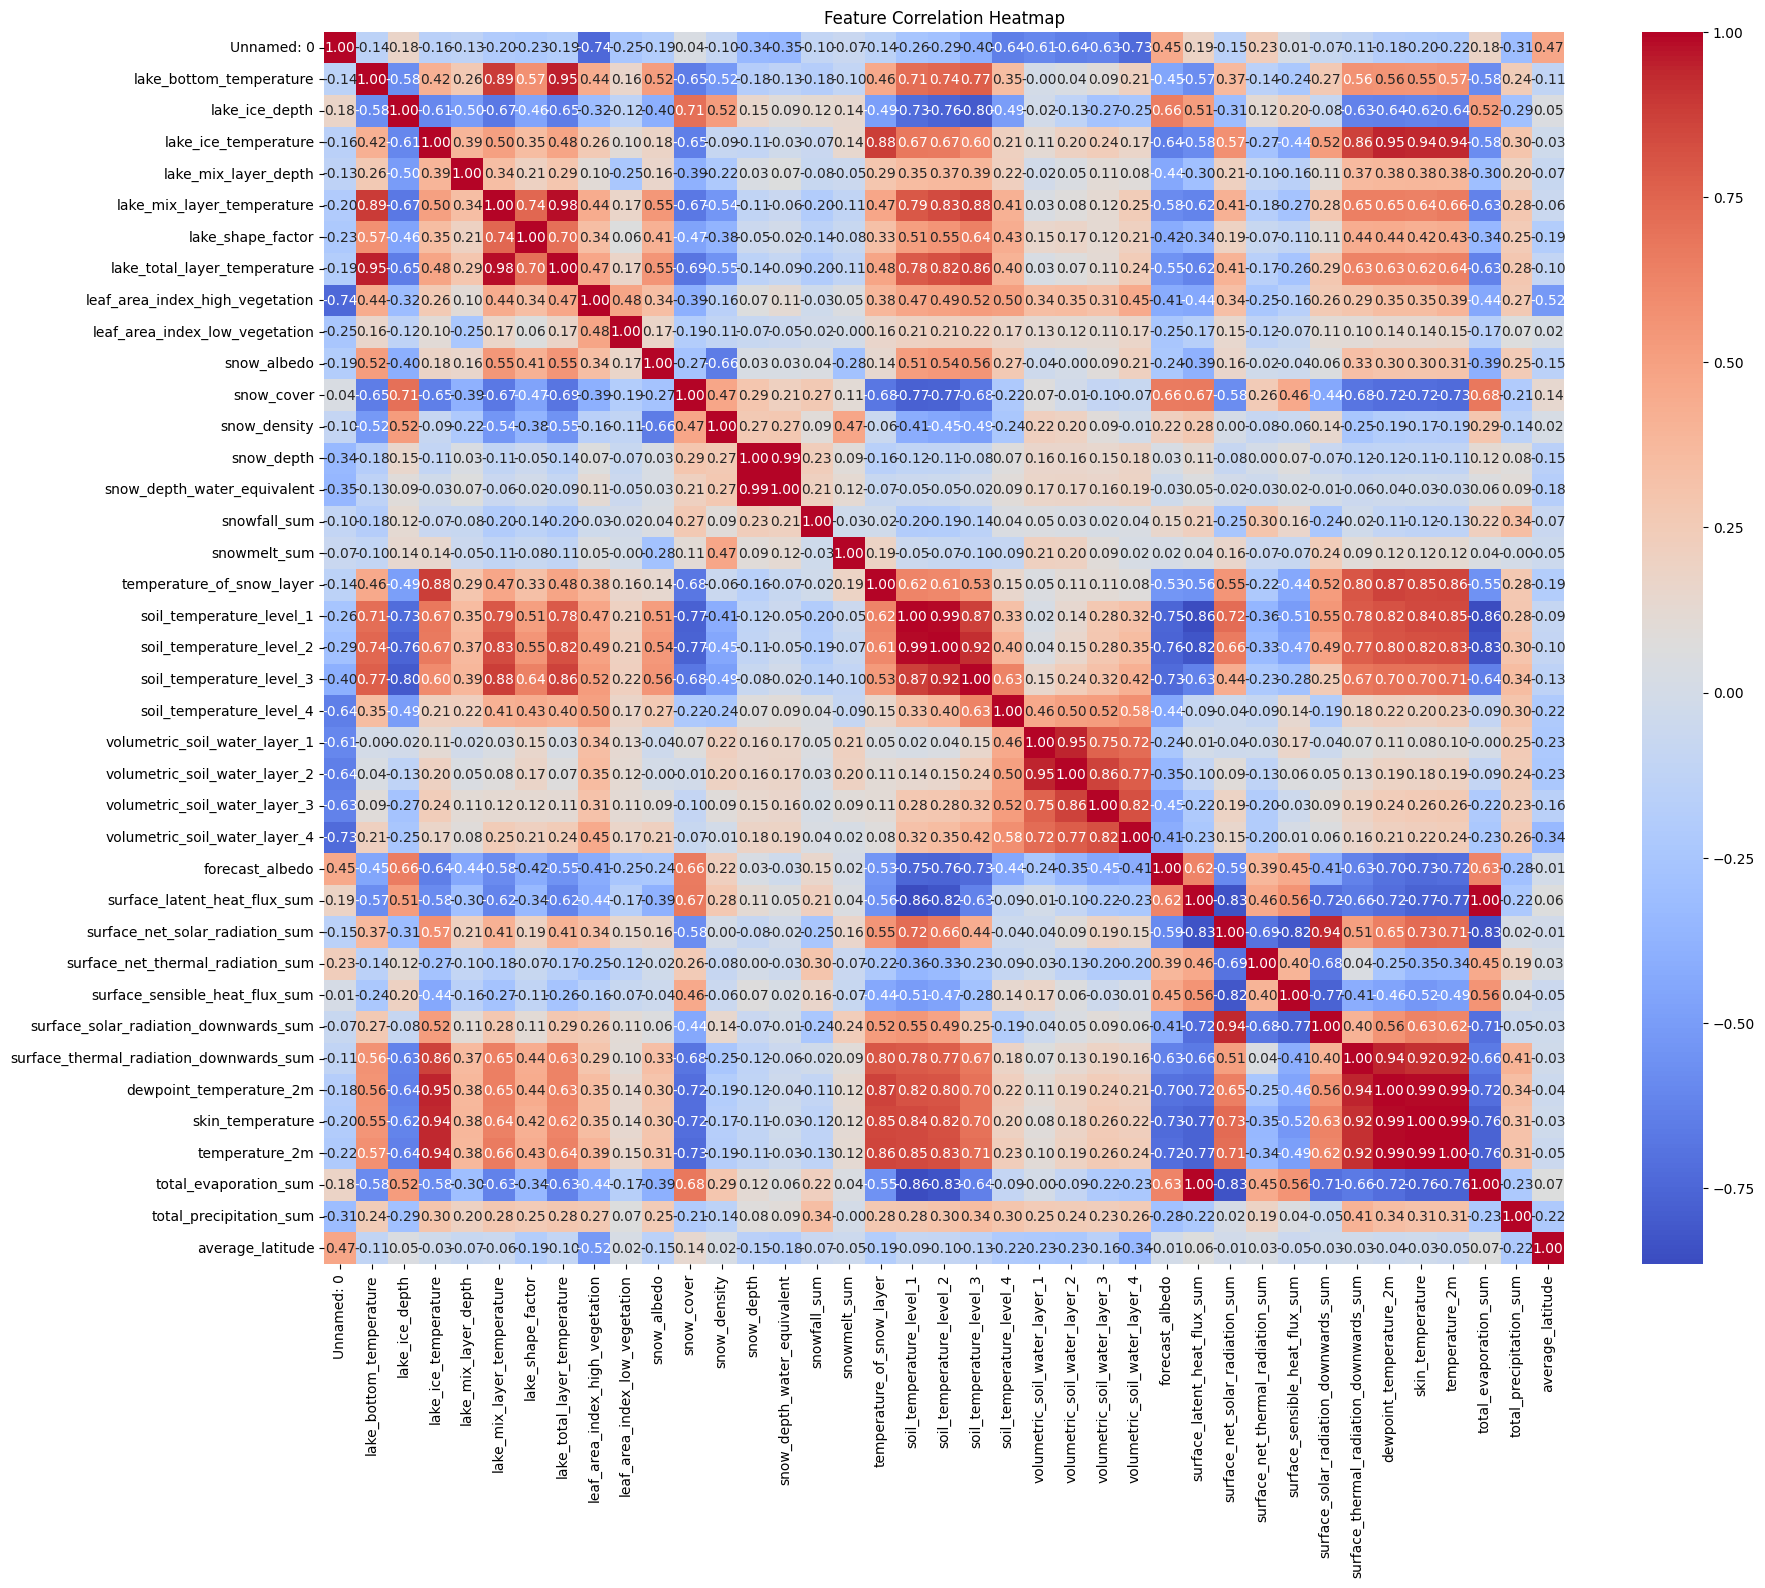

In [15]:
# view heatmap

plt.figure(figsize=(20, 16))
sns.heatmap(permafrost_data_new.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Obersvations:
- Soil temperature for all levels are correlated with each other, and volumetric soil water content for all levels are also correlated with each other. Create new columns for each of them that take the mean correspondingly.
- Air temperature features (`'dewpoint_temperature_2m'` and `'temperature_2m'`) are highly correlated. Drop `'dewpoint_temperature_2m'`.
- Snow properties (`'snow_depth'` and `'snow_depth_water_equivalent'`) are also highly correlated. Drop `'snow_depth_water_equivalent'`.
- Lake temperature properties (`'lake_bottom_temperature'`, `'lake_mix_layer_temperature'`and `'lake_total_layer_temperature'`). Rename `'lake_total_layer_temperature'` into `'average_lake_temperature'` and drop the other two.
- Completely drop `'total_evaporation_sum'`.

## **Perform Changes**


In [35]:
permafrost_data['avg_soil_temperature'] = permafrost_data[['soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4']].mean(axis=1)

In [36]:
permafrost_data['avg_volumetric_water_content'] = permafrost_data[['volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4']].mean(axis=1)
permafrost_data.drop(columns=['volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4'], axis=1, inplace=True)

In [39]:
to_drop = ['soil_temperature_level_1', 'soil_temperature_level_2',
           'soil_temperature_level_3', 'soil_temperature_level_4',
           'total_evaporation_sum', 'dewpoint_temperature_2m',
           'snow_depth_water_equivalent', 'lake_bottom_temperature',
           'lake_mix_layer_temperature']

In [40]:
permafrost_data.drop(columns=to_drop, axis=1, inplace=True)

In [42]:
permafrost_data.rename(columns={'lake_total_layer_temperature': 'average_lake_temperature'}, inplace=True)

In [43]:
# check new columns
permafrost_data.columns

Index(['Unnamed: 0', 'date', 'lake_ice_depth', 'lake_ice_temperature',
       'lake_mix_layer_depth', 'lake_shape_factor', 'average_lake_temperature',
       'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation',
       'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth',
       'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer',
       'forecast_albedo', 'surface_latent_heat_flux_sum',
       'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum',
       'surface_sensible_heat_flux_sum',
       'surface_solar_radiation_downwards_sum',
       'surface_thermal_radiation_downwards_sum', 'skin_temperature',
       'temperature_2m', 'total_precipitation_sum', 'band', 'average_latitude',
       'TBFI_skin_temperature', 'TBFI_soil_temperature_level_1',
       'TBFI_soil_temperature_level_2', 'TBFI_soil_temperature_level_3',
       'avg_soil_temperature', 'avg_volumetric_water_content'],
      dtype='object')

In [44]:
permafrost_data.shape

(50262, 34)

In [45]:
permafrost_data_new = permafrost_data.drop(columns=['date', 'band', 'TBFI_skin_temperature', 'TBFI_soil_temperature_level_1',
       'TBFI_soil_temperature_level_2', 'TBFI_soil_temperature_level_3'], axis=1)

In [46]:
vif_result = compute_vif(permafrost_data_new)
vif_result

,feature,VIF
0,Unnamed: 0,48.218269
1,lake_ice_depth,16.243330
2,lake_ice_temperature,57.524114
3,lake_mix_layer_depth,5.584337
4,lake_shape_factor,547.272032
5,average_lake_temperature,11.921281
6,leaf_area_index_high_vegetation,22.970165
7,leaf_area_index_low_vegetation,12.652284
8,snow_albedo,131.096546
9,snow_cover,19.222556


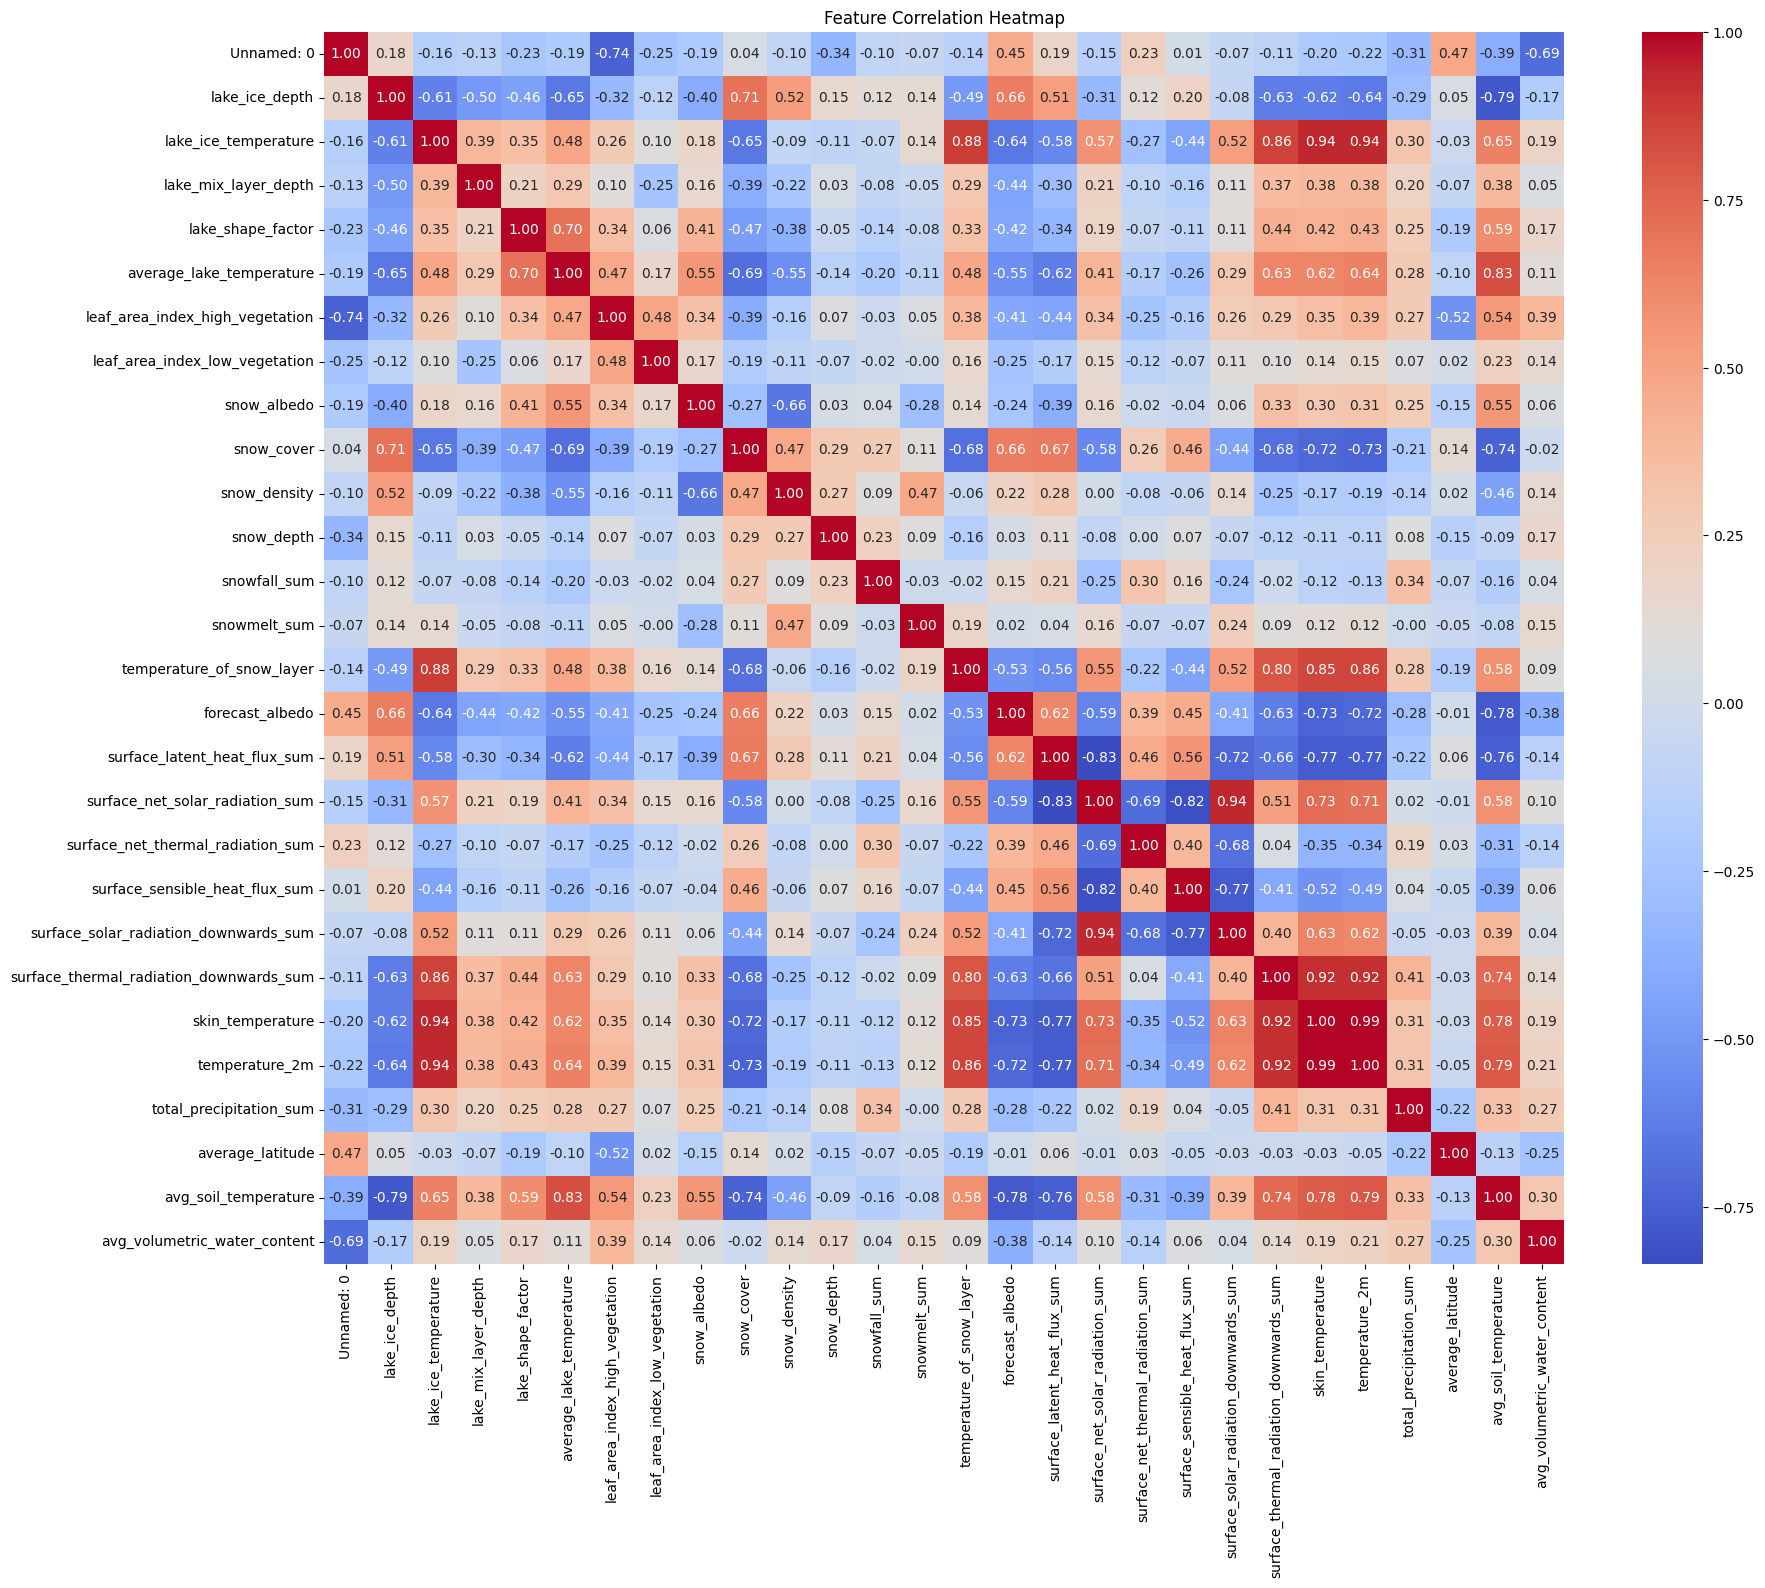

In [47]:
plt.figure(figsize=(20, 16))
sns.heatmap(permafrost_data_new.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Since a lot of the features with high VIF's are important for later analysis, we will keep them. The features with high pearson correlations have been significantly reduced.

# **Z-Score Normalization**

In [48]:
scaler = StandardScaler()

In [49]:
scaled = scaler.fit_transform(permafrost_data_new)

In [53]:
scaled_df = pd.DataFrame(scaled, columns=permafrost_data_new.columns)

In [54]:
# add back labels and non-numeric columns
alaska_permafrost_data_preprocessed = pd.concat([permafrost_data[['date', 'band']], scaled_df, permafrost_data[['TBFI_skin_temperature', 'TBFI_soil_temperature_level_1',
       'TBFI_soil_temperature_level_2', 'TBFI_soil_temperature_level_3']]], axis=1)

In [55]:
alaska_permafrost_data_preprocessed.columns

Index(['date', 'band', 'Unnamed: 0', 'lake_ice_depth', 'lake_ice_temperature',
       'lake_mix_layer_depth', 'lake_shape_factor', 'average_lake_temperature',
       'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation',
       'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth',
       'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer',
       'forecast_albedo', 'surface_latent_heat_flux_sum',
       'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum',
       'surface_sensible_heat_flux_sum',
       'surface_solar_radiation_downwards_sum',
       'surface_thermal_radiation_downwards_sum', 'skin_temperature',
       'temperature_2m', 'total_precipitation_sum', 'average_latitude',
       'avg_soil_temperature', 'avg_volumetric_water_content',
       'TBFI_skin_temperature', 'TBFI_soil_temperature_level_1',
       'TBFI_soil_temperature_level_2', 'TBFI_soil_temperature_level_3'],
      dtype='object')

In [57]:
alaska_permafrost_data_preprocessed.drop('Unnamed: 0', axis=1, inplace=True)

In [58]:
alaska_permafrost_data_preprocessed.shape

(50262, 33)

In [59]:
alaska_permafrost_data_preprocessed.head()

,date,band,lake_ice_depth,lake_ice_temperature,lake_mix_layer_depth,lake_shape_factor,average_lake_temperature,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,snow_albedo,...,skin_temperature,temperature_2m,total_precipitation_sum,average_latitude,avg_soil_temperature,avg_volumetric_water_content,TBFI_skin_temperature,TBFI_soil_temperature_level_1,TBFI_soil_temperature_level_2,TBFI_soil_temperature_level_3
0,2001-01-01,band_1,0.015986,0.054556,-0.856931,-0.635093,-0.499380,0.341992,0.260449,0.405087,...,-0.257017,-0.276932,0.182966,-1.224745,-0.243406,0.892639,-0.445693,1.261128,1.400449,2.131843
1,2001-01-02,band_1,0.025821,-0.146885,-0.856931,-0.635093,-0.499407,0.339136,0.260449,0.376984,...,-0.368480,-0.429463,-0.027389,-1.224745,-0.247401,0.880851,-0.445693,1.261128,1.400449,2.131843
2,2001-01-03,band_1,0.040125,-0.661080,-0.856931,-0.635093,-0.499362,0.336399,0.260449,0.357042,...,-0.704250,-0.788808,0.880438,-1.224745,-0.255207,0.869549,-0.445693,1.261128,1.400449,2.131843
3,2001-01-04,band_1,0.060023,-1.102662,-0.856931,-0.635093,-0.499307,0.333549,0.260254,0.341331,...,-1.040047,-1.121532,0.721379,-1.224745,-0.268143,0.857634,-0.445693,1.261128,1.400449,2.131843
4,2001-01-05,band_1,0.083029,-1.348047,-0.856931,-0.635093,-0.499271,0.330693,0.260245,0.284666,...,-1.210734,-1.319825,-0.555862,-1.224745,-0.283891,0.846426,-0.445693,1.261128,1.400449,2.131843


# **Save Preprocessed DataFrame**

In [60]:
# if using colab
output_path = userdata.get('preprocessed_path')
alaska_permafrost_data_preprocessed.to_csv(output_path)